In [12]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import numpy as np
from skimage.measure import label, regionprops
from scipy.ndimage.morphology import distance_transform_edt
import time
import pytesseract
from skimage.transform import rescale, resize
from skimage.util import invert
from skimage.morphology import binary_closing

from tensorflow import keras
from skimage import exposure

# adjust gamma
cimage = imread('../sample_images/image12.jpeg')
cimage = exposure.adjust_gamma(cimage, 1.2)

# load the keras digit recognizer
all_characters = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')

# convert to grayscale
img = rgb2gray(cimage)

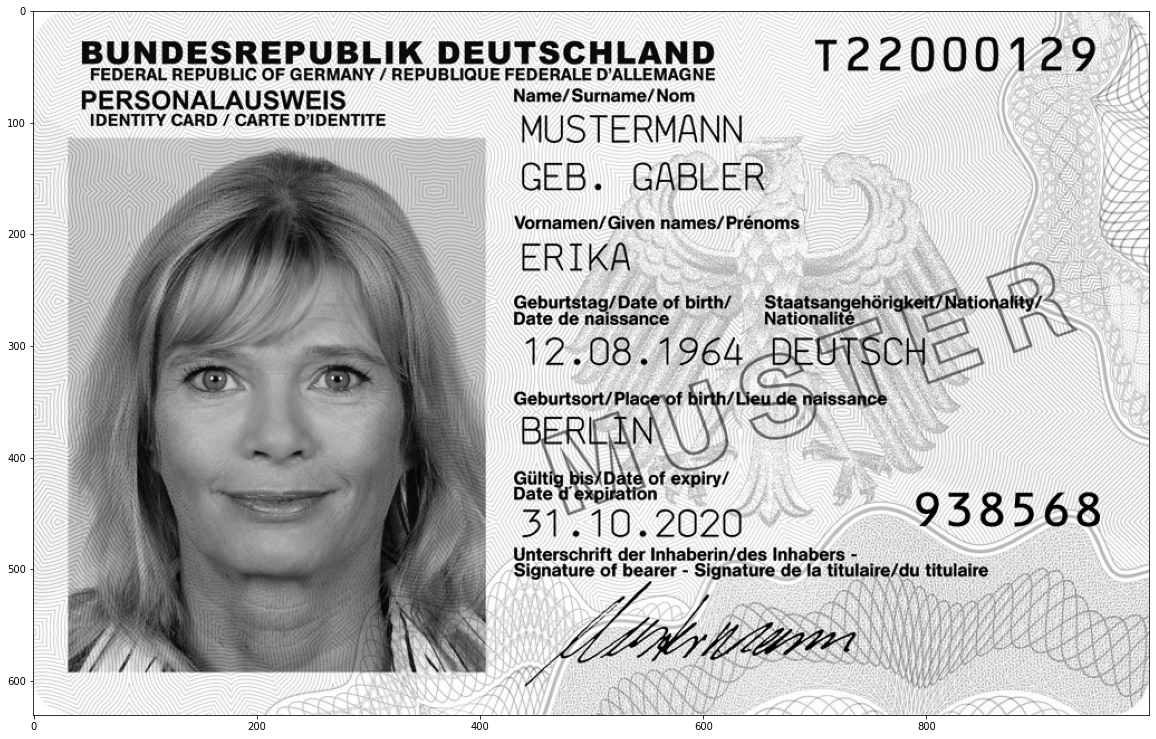

In [13]:
# preview the image
plt.figure(figsize=(20,20))
plt.imshow(img, cmap="gray")

total time taken: 6862


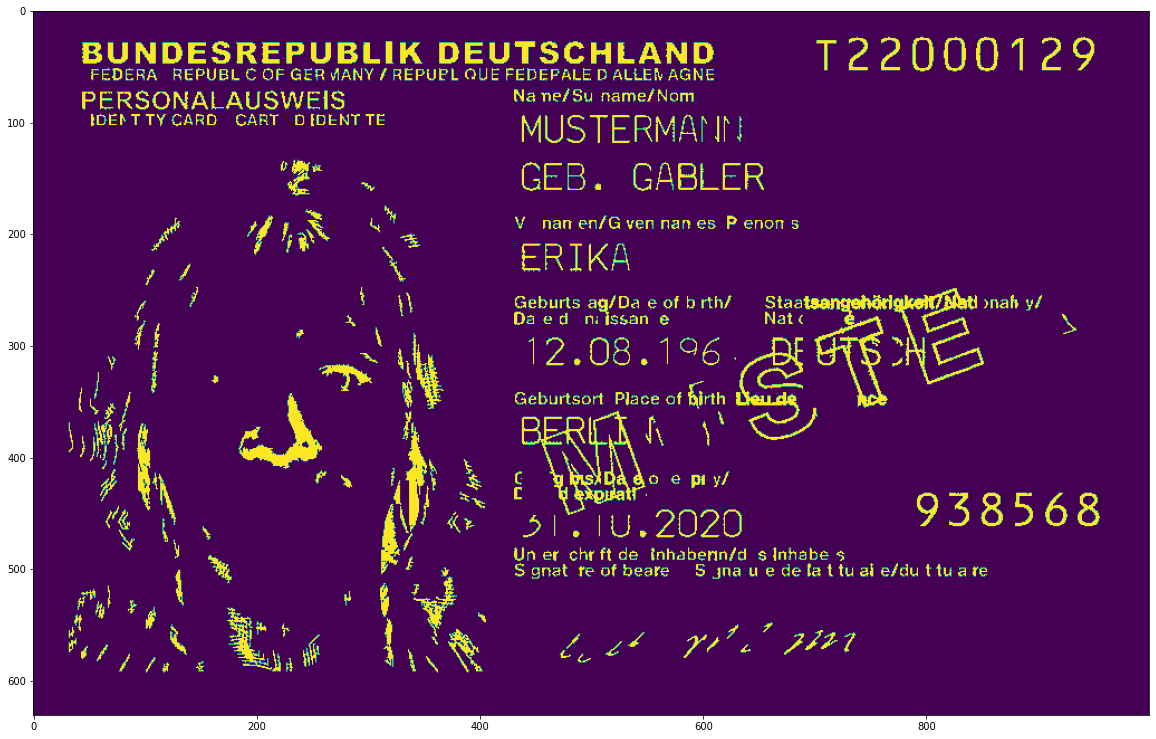

In [14]:
import math

final_thresholded_image = np.zeros(img.shape)
st_time = int(round(time.time() * 1000))
multilayer_prediction_map = {}
multilayer_prediction_map_recorded = []

def predict_alphanumer(img):
    predicted = reconstructed_model.predict(rescale_for_recognition(img).reshape(1,32,32,1))
    predicted = all_characters[np.argmax(predicted)]
    if predicted.isalnum():
        return predicted
    return ''

def rescale_for_recognition(character_img):
    character_img = binary_closing(character_img)
    resized = rescale(character_img,2,multichannel=False)
    r, c = resized.shape
    rescaled = rescale(resized, np.minimum(20 / r, 20 / c), multichannel=False) > 0.1
    # fit it inside a 32 x 32 box, centered
    r, c = rescaled.shape
    r_dist = int((32 - r) / 2)
    c_dist = int((32 - c) / 2)
    digit = np.ones((32, 32), dtype=np.int8)
    digit[r_dist:r_dist + r, c_dist:c_dist + c] = invert(rescaled)
    return digit

def round5(x):
    return int(x / 10) * 10 + 10 if (x % 10) >= 5 else int(x / 10) * 10

def is_not_recorded(region):
    centroid = list(region.centroid)
    centroid[0] = round5(centroid[0])
    centroid[1] = round5(centroid[1])
    centroid_id = str(centroid[0])+"_"+str(centroid[1])
    if centroid_id not in multilayer_prediction_map_recorded:
        return True
    return False

def record_region(region):
    centroid = list(region.centroid)
    centroid[0] = round5(centroid[0])
    centroid[1] = round5(centroid[1])
    centroid_id = str(centroid[0])+"_"+str(centroid[1])
    multilayer_prediction_map_recorded.append(centroid_id)
    
def remove_non_text_like_regions(image, original_gray_img):
    ret_img = np.copy(image)
    label_image = label(image, connectivity=1)
    img_height, img_weight = image.shape
    for region in regionprops(label_image):
        if is_not_recorded(region):
            minr, minc, maxr, maxc = region.bbox
            height = maxr - minr
            width = maxc - minc
            aspect_ratio = width/height
            should_clean = region.area < 15 * (img_height * img_weight / (600**2))
            should_clean = should_clean or (region.area > (img_height*img_weight/5))
            should_clean = should_clean or aspect_ratio < 0.06  or aspect_ratio > 2
            should_clean = should_clean or region.eccentricity > 0.995
            should_clean = should_clean or region.solidity < 0.3
            should_clean = should_clean or region.extent < 0.2 or region.extent > 0.9
            should_clean = should_clean or (math.degrees(region.orientation) < -45 and (region.major_axis_length / region.minor_axis_length) > 1.5)
            strokeWidthValues = distance_transform_edt(region.image)
            flat = strokeWidthValues.flatten()
            flat = flat[flat > 0]
            coefficient_of_variation = np.std(flat)/np.mean(flat)
            should_clean = should_clean or coefficient_of_variation > 0.6
            if not should_clean:
                final_thresholded_image[minr:maxr, minc:maxc] = region.image
                record_region(region)
                
    return ret_img

# thresholding the image under different thresholds
binary_images = []
threshold_values = np.arange(0.1,0.7, 0.02)
for threshold in threshold_values:
    binary_images.append(remove_non_text_like_regions(img < threshold, img))

end_time = int(round(time.time() * 1000))
print("total time taken:", (end_time - st_time))

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(final_thresholded_image)
plt.show()

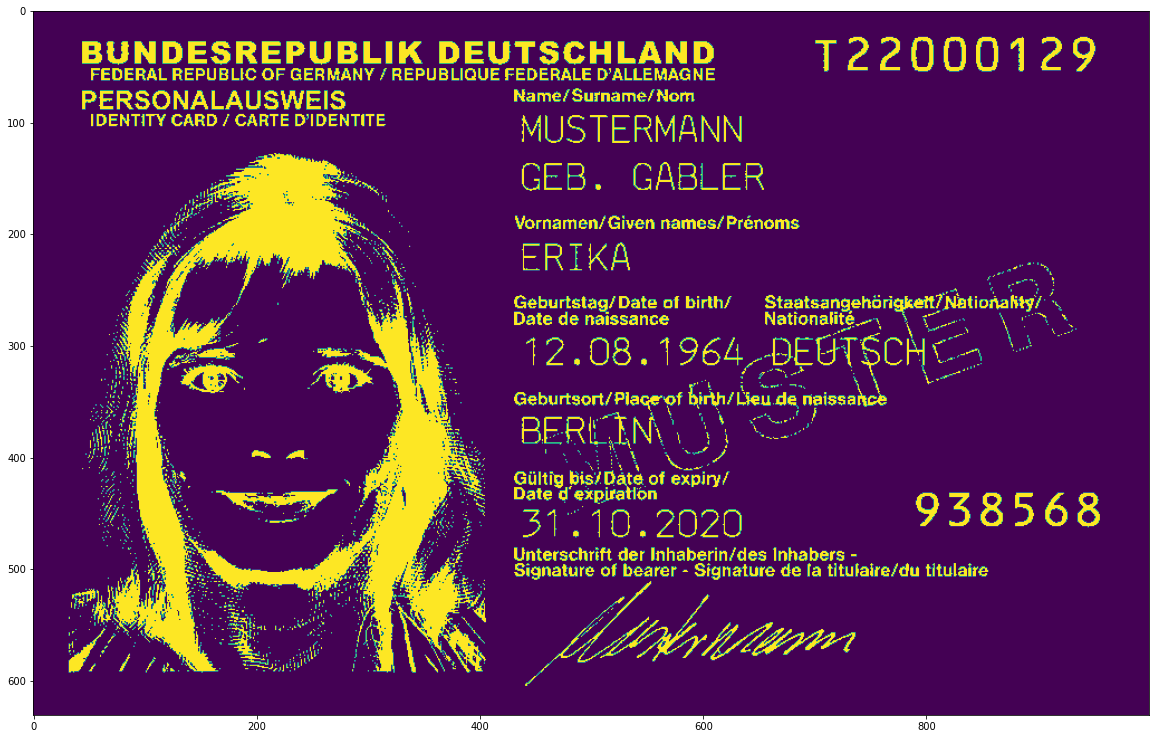

In [15]:
import math 

# cleaned_image = np.zeros(img.shape)
# label_image = label(final_thresholded_image, connectivity=1)
# for region in regionprops(label_image):
#     minr, minc, maxr, maxc = region.bbox
#     #print(math.degrees(region.orientation))
#     should_clean = math.degrees(region.orientation) > 45 #and (region.major_axis_length / region.minor_axis_length) > 1.5
#     if should_clean:
#         print(region.major_axis_length / region.minor_axis_length)
#         cleaned_image[minr:maxr, minc:maxc] = region.image

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img < 0.4)
plt.show()